In [12]:
from keras.datasets import mnist
import numpy as np
from keras.layers import Input, Dense, Flatten, Reshape, GaussianNoise, Activation, Subtract
from keras.layers import LSTM, GRU, SimpleRNN, TimeDistributed, Multiply, Add
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import  Bidirectional
from keras.models import Model
import tensorflow as tf
import keras.backend as K
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# start to learn code
def create_fcnn_model(encoding_dim, input_dim, sigma):
    # step activation
    def bpsk_activation(x):
        return K.sign(x - 0.5)
    
    def step_activation(x):
        return K.sign(x)
    
    # Энкодер
    input_layer = Input(shape=(input_dim,))
    x = Dense(encoding_dim*3, activation='relu')(input_layer)
    x = Dense(encoding_dim*2, activation='relu')(x)
    x = Dense(encoding_dim, activation='sigmoid')(x)
    
    # BPSK
    # encoded = Activation(bpsk_activation)(x)
    
    # Noise
    input_noise = Input(shape=(encoding_dim,))
    noised = GaussianNoise(sigma)(input_noise, training=True)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    x = Dense(encoding_dim * 2, activation='relu')(input_encoded)
    x = Dense(encoding_dim * 3, activation='relu')(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)
    
    # Модели
    encoder = Model(input_layer, encoded, name="encoder")
    noise = Model(input_noise, noised, name = "noise");
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_layer, decoder(noise(encoder(input_layer))), name="autoencoder")
    return encoder, decoder, autoencoder, noise


In [14]:
def int2bits(i, padding):
    return np.array(list(bin(i)[2:].zfill(padding)), dtype=int) 

In [15]:
def ber(X_pred, X_train):
    
    l = ( X_pred == X_train).sum()
    
    n = X_train.shape[0] * X_train.shape[1]

    return 1 - l / n

In [16]:
def hard(arr, threshold=0.5):
    return arr > threshold 

In [19]:
# LEARN
# start to learn code
def create_gru_model(coderate, input_dim, sigma):
    # step activation
    def bpsk_activation(x):
        return K.sign(x - 0.5)
    
    def scale_activation(x):
        return 2 * (x - 0.5)
    
    enc_gru_units = 25
    dec_gru_units = 100
    # Энкодер
    x = Input(shape=(input_dim, 1))
    gru_enc1 = GRU(name='enc_gru_1', units=enc_gru_units, activation='tanh', return_sequences=True, dropout=1.0)
    gru_enc2 = GRU(name='enc_gru_2', units=enc_gru_units, activation='tanh', return_sequences=True, dropout=1.0)
    output_enc = Dense(coderate, activation='sigmoid') # try timedistributed
    
    encoded = output_enc(gru_enc2(gru_enc1(x)))
    # BPSK
    # encoded = Activation(bpsk_activation)(encoded)
    encoded = Activation(scale_activation)(encoded)
    # Noise
    input_noise = Input(shape=(input_dim, coderate))
    # noise = GaussianNoise(sigma)(K.zeros(shape=(input_dim, coderate)), training=True)
    # noised = Add()([input_noise, noise])
    noised = GaussianNoise(sigma)(input_noise, training=True)
    
    # Декодер
    y = Input(shape=(input_dim, coderate))
    gru_dec1 = GRU(name='dec_gru_1', units=dec_gru_units, activation='tanh', return_sequences=True, dropout=1.0)
    gru_dec2 = GRU(name='dec_gru_2', units=dec_gru_units, activation='tanh', return_sequences=True, dropout=1.0)
    gru_dec3 = GRU(name='dec_gru_3', units=dec_gru_units, activation='tanh', return_sequences=True, dropout=1.0)
    gru_dec4 = GRU(name='dec_gru_4', units=dec_gru_units, activation='tanh', return_sequences=True, dropout=1.0)
    output_dec = Dense(1, activation='sigmoid')
    
    decoded = output_dec(gru_dec4(gru_dec3(gru_dec2(gru_dec1(y)))))
    
    # Модели
    encoder = Model(x, encoded, name="encoder")
    #encoder.summary()
    noise = Model(input_noise, noised, name = "noise");
    noise.summary()
    decoder = Model(y, decoded, name="decoder")
    #decoder.summary()
    autoencoder = Model(x, decoder(noise(encoder(x))), name="autoencoder")
    return encoder, decoder, autoencoder, noise

coderate = 2
k = 10
total_count = 2 ** k;
sigma = get_sigma(2)

X_train = np.array([int2bits(i, k) for i in range(total_count)])
X_train = X_train.reshape((total_count, k, 1))
enc, dec, autoencoder, noise = create_gru_model(coderate, k, sigma)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=128,
                shuffle=True)

X_pred = autoencoder.predict(X_train)

Model: "noise"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 10, 2)             0         
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 10, 2)             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1024/1024 [==============================] - 3s 3ms/step - loss: 0.6934
Epoch 2/100
1024/1024 [==============================] - 1s 697us/step - loss: 0.6934
Epoch 3/100
1024/1024 [==============================] - 1s 678us/step - loss: 0.6933
Epoch 4/100
1024/1024 [==============================] - 1s 675us/step - loss: 0.6933
Epoch 5/100
1024/1024 [==============================] - 1s 674us/step - loss: 0.6932
Epoch 6/100
1024/1024 [==============================] - 1s 670us/step - loss: 0.6932
Epoch 7/100
102

1024/1024 [==============================] - 1s 694us/step - loss: 0.1004
Epoch 88/100
1024/1024 [==============================] - 1s 681us/step - loss: 0.0982
Epoch 89/100
1024/1024 [==============================] - 1s 668us/step - loss: 0.1059
Epoch 90/100
1024/1024 [==============================] - 1s 678us/step - loss: 0.1004
Epoch 91/100
1024/1024 [==============================] - 1s 684us/step - loss: 0.0951
Epoch 92/100
1024/1024 [==============================] - 1s 704us/step - loss: 0.1035
Epoch 93/100
1024/1024 [==============================] - 1s 666us/step - loss: 0.1021
Epoch 94/100
1024/1024 [==============================] - 1s 672us/step - loss: 0.1018
Epoch 95/100
1024/1024 [==============================] - 1s 670us/step - loss: 0.0985
Epoch 96/100
1024/1024 [==============================] - 1s 667us/step - loss: 0.1031
Epoch 97/100
1024/1024 [==============================] - 1s 664us/step - loss: 0.0950
Epoch 98/100
1024/1024 [==============================] 

In [21]:
ber(hard(X_pred), X_train)

0.04013671875000002

In [22]:
def get_sigma(snr):
    return 10 ** (-snr * 1.0/20)

def simulate_sigma(k, enc, dec, sigma, batch_count=100, batch_size=256):
    err = 0.0;
    for i in range(batch_count):
        X = np.random.randint(2, size=(batch_size, k, 1))
       
        Y = enc.predict(X)
        Y_noised= Y + np.random.normal(loc=0.0, scale=sigma, size=Y.shape)
        X_pred = dec.predict(Y_noised)
        err += ber(hard(X_pred), X)
        
    err /= batch_count
    return err

def simulate_model_fixed_snr(k, enc, dec, snr_arr):
    ber_arr = []
    for snr in snr_arr:
        sigma = get_sigma(snr)
        err = simulate_sigma(k, enc, dec, sigma)
        ber_arr.append(err)
    
    return ber_arr


In [23]:
snr_arr = [0, 1, 2, 3, 4]
ber_fixed_arr = simulate_model_fixed_snr(k, enc, dec, snr_arr)

In [24]:
def simulate_repetition_sigma(k, coderate, sigma):
    batch_size = 256
    batch_count = 100
    
    err = 0.0
    for i in range(batch_count):
        X = np.random.randint(2, size=(batch_size, k, 1))
        rep = np.ones(shape=(coderate, 1))
        Y = np.kron(X, rep)
        Y[Y == 0] = -1
        Y_noised = Y + np.random.normal(loc=0.0, scale=sigma, size=Y.shape)
        
        # decoding
        X_pred = np.zeros(shape=(batch_size, k, 1))
        for j in range(batch_size):
            for l in range(k):
                temp = 0.0
                for t in range(coderate):
                    temp += Y_noised[j, l * coderate + t, 0]
                X_pred[j, l, 0] = 1 if temp > 0 else 0
        
        err += ber(X_pred, X)
    err /= batch_count
    return err

def simulate_repetition(k, coderate, snr_arr):
    ber_arr = []
    for snr in snr_arr:
        sigma = get_sigma(snr)
        err = simulate_repetition_sigma(k, coderate, sigma)
        ber_arr.append(err)
    
    return ber_arr

rep_arr = simulate_repetition(k, coderate, snr_arr)

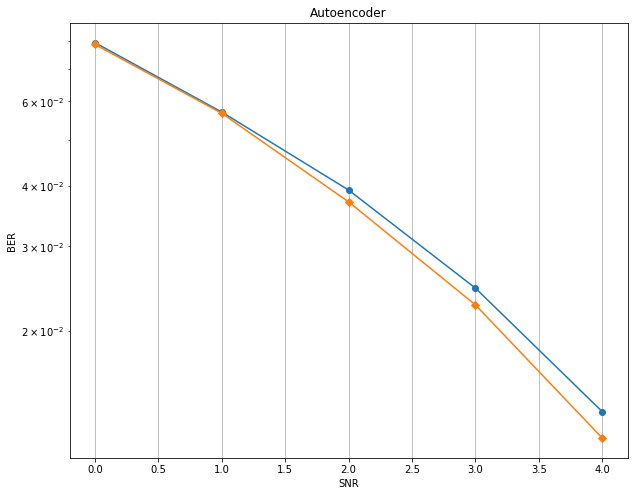

In [25]:
plt.figure(figsize=(10,8))
plt.plot(snr_arr, ber_fixed_arr, '-o', snr_arr, rep_arr, '-D');
plt.title("Autoencoder")
plt.xlabel("SNR")
plt.grid(True)
plt.ylabel("BER")
plt.yscale('log')
plt.xscale('linear')

In [28]:
enc.predict(int2bits(3, k).reshape(1, k, 1))

array([[[-0.9765387 ,  0.9604392 ],
        [-0.99758536,  0.9952141 ],
        [-0.9991087 ,  0.99836946],
        [-0.9993775 ,  0.9989996 ],
        [-0.99945533,  0.9992131 ],
        [-0.99948317,  0.9993057 ],
        [-0.9994932 ,  0.99934936],
        [-0.9994965 ,  0.9993713 ],
        [ 0.9994396 , -0.9994776 ],
        [ 0.9994391 , -0.99951595]]], dtype=float32)